In [1]:
import serial as ser
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import time
%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

In [2]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-DJ00DVYG - FT231X USB UART - FT231X USB UART


<IPython.core.display.Javascript object>


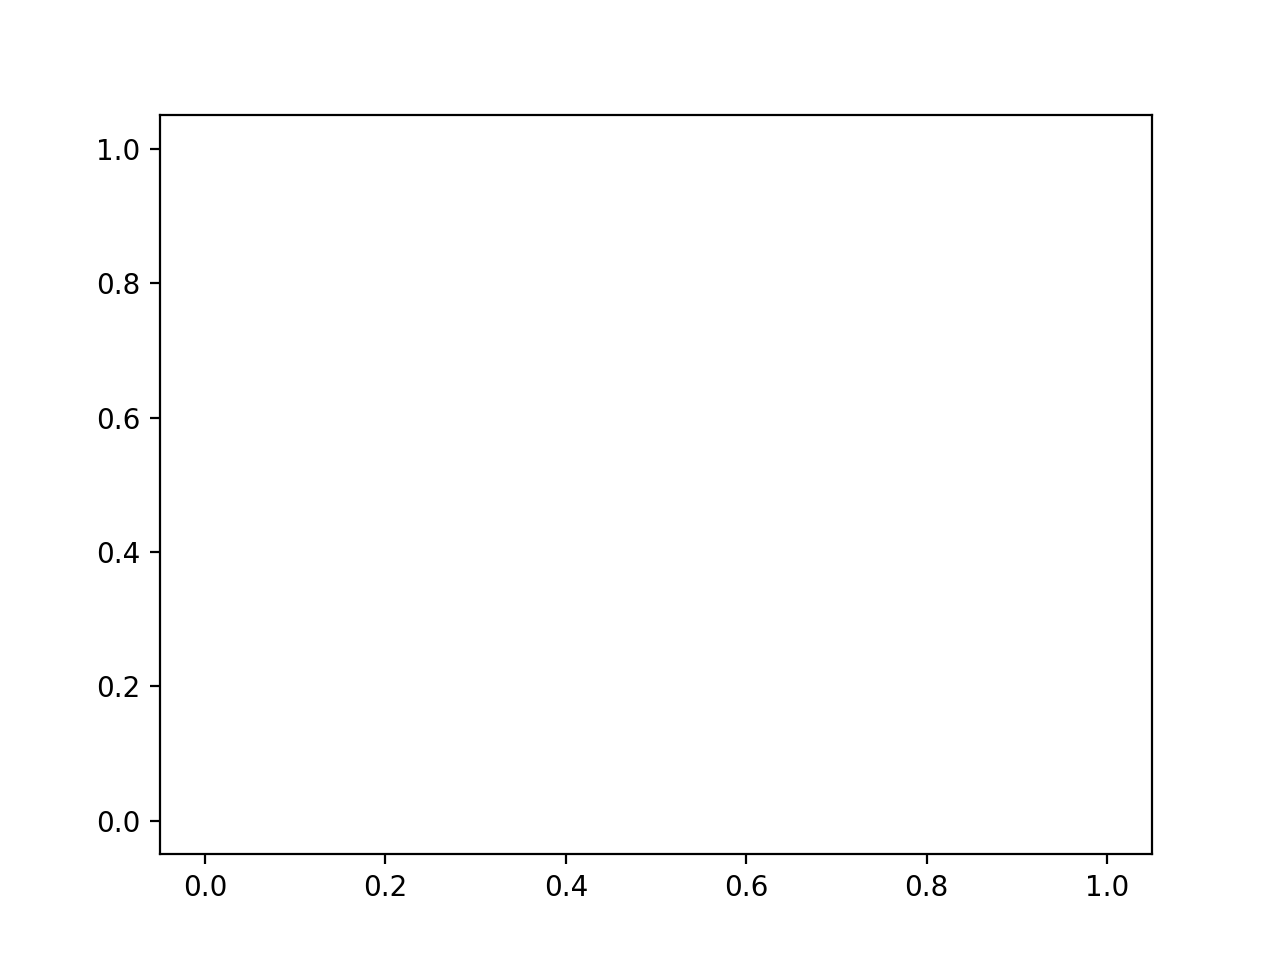

In [3]:
# Read example data
baudrate = 230400
cport = '/dev/cu.usbserial-DJ00DVYG'  # set the correct port before you run it
ser = ser.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/20000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)
data = read_arduino(ser,inputBufferSize)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()
 

<IPython.core.display.Javascript object>


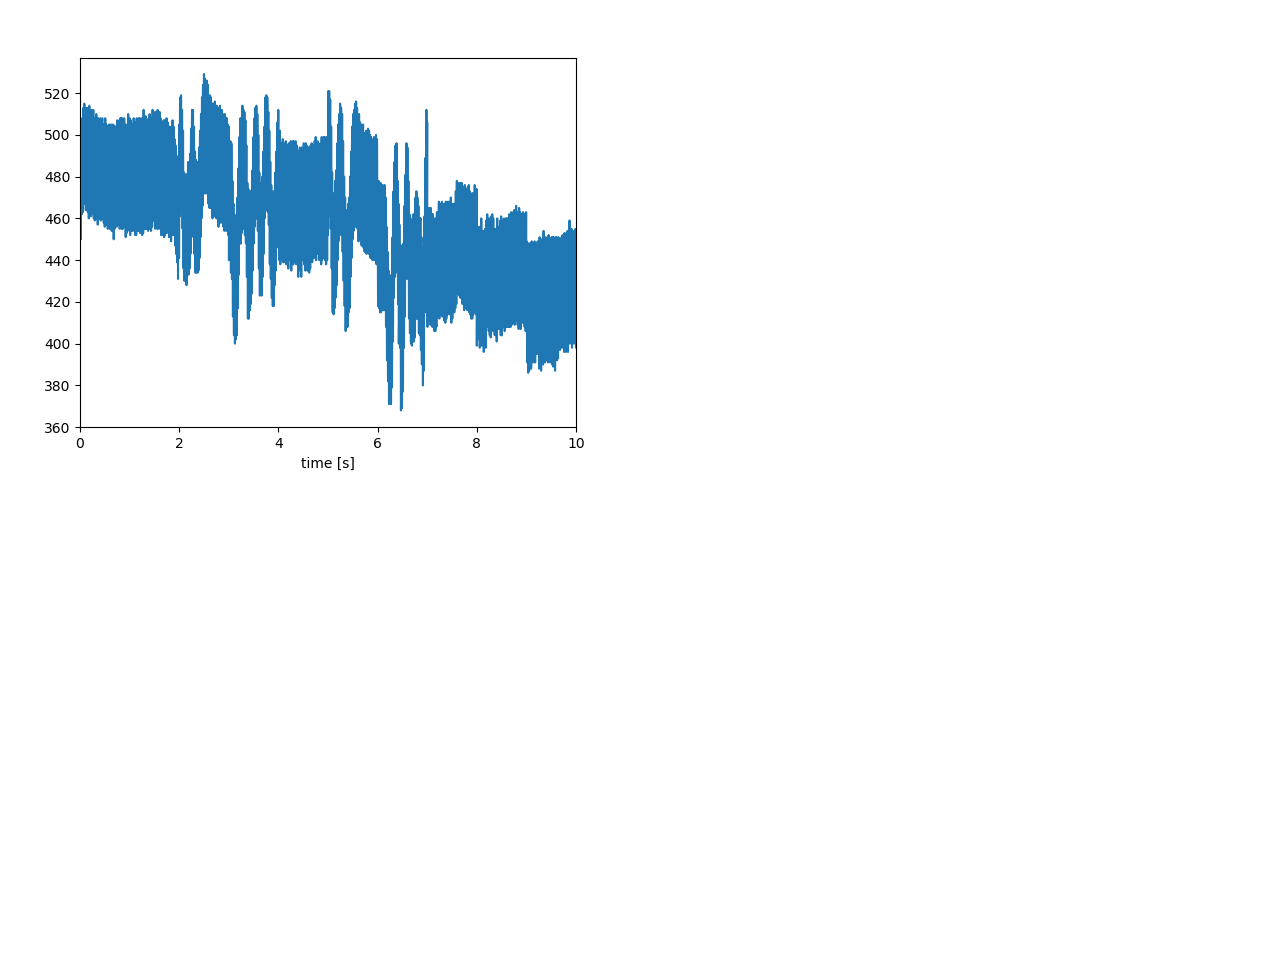

9.469243414338866
45.0
514.421

578.0
calibration done!
12.889641503850719
85.25
40.25
540
15
L
L
R
R
R
fl
fl
L
fl
R
R
fl
L
fl
L
L
R
fl
R
fl
fl
fl
fl
fl
fl
L
fl
fl
fl
fl
fl
R
L
R


KeyboardInterrupt: 

In [12]:
# take continuous data stream 
inputBufferSize = 20002 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#this is the problem line on the mac
# ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib notebook

total_time = 100.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()

def Detection(seq, std_thresh, diff_thresh, height_thresh, prom_thresh):
    std = np.std(seq)
    diff = np.max(seq) - np.min(seq)
    peaks = len(scipy.signal.find_peaks(seq, height=height_thresh, prominence=prom_thresh)[0])
    maxval = np.argmax(seq)
    minval = np.argmin(seq)
    if peaks > 8 and diff < 100:
        return 'fl'
    elif std > std_thresh and diff > diff_thresh:
        if maxval > minval:
            return 'L'
        else:
            return 'R'
    else:
        return 'NA'
    
last_seq = np.empty(0)

q = 0
count = 0
previous = 'NA'

best_diff = 0
best = 0

calibrating = True
start = True
cal_count = 0
current_detection = 0
max_cstd = 0
max_cdiff = 0
max_ch = 0
nas = 0

for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    
    combined = np.concatenate((last_seq, data_temp), axis=None)
    combined = np.flip(combined)
    
    if calibrating and q > 0:
        if start:
            arrs = np.split(data_temp, 5)
            means = np.empty(0)
            for p in arrs:
                means = np.append(means, np.mean(p))
            base_h = np.median(means)
            base_std = np.std(data_temp)
            base_diff = np.max(data_temp) - np.min(data_temp)
            print(base_std)
            print(base_diff)
            print(base_h)
            print()
            #print(m)
            start = False
            #calibrating = False
        else:
            p = 0
            movement = len(combined) - 10000
            while movement - p > 0:
                interval = combined[p:(p+10000)]
                cstd = np.std(interval)
                cdiff = np.max(interval) - np.min(interval)
                ch = np.max(interval)
                if cstd > 1.2 * base_std:
                    cal_count += 1
                    nas = 0
                    if cstd > max_cstd:
                        max_cstd = cstd
                    if cdiff > max_cdiff:
                        max_cdiff = cdiff
                    if ch > max_ch:
                        max_ch = ch
                elif cal_count > 8:
                    current_detection += 1
                    if current_detection == 1:
                        lstd = max_cstd
                        ldiff = max_cdiff
                        lch = max_ch
                        max_cstd = 0
                        max_cdiff = 0
                        max_ch = 0
                    elif current_detection == 2:
                        rstd = max_cstd
                        rdiff = max_cdiff
                        rch = max_ch
                        max_cstd = 0
                        max_cdiff = 0
                        max_ch = 0
                    else:
                        fstd = max_cstd
                        fdiff = max_cdiff
                        fch = max_ch
                        print(fch)
                        calibrating = False
                        print('calibration done!')
                        max_cstd = 0
                        max_cdiff = 0
                        max_ch = 0

                        min_std = np.min(np.array([lstd, rstd, fstd]))
                        max_std = np.max(np.array([lstd, rstd, fstd]))
                        std_threshold = base_std + (min_std - base_std)*0.25

                        min_diff = np.min(np.array([ldiff, rdiff]))
                        diff_threshold = base_diff + (min_diff - base_diff)*0.25
                        diff_threshold2 = (min_diff - base_diff)*0.25

                        height_threshold = 540 #base_h + (fch - base_h)/2
                        prom_threshold = 15 #(fch - base_h)/2
                        print(std_threshold)
                        print(diff_threshold)
                        print(diff_threshold2)
                        print(height_threshold)
                        print(prom_threshold)

                    cal_count = 0
                    nas += 1
                else:
                    cal_count = 0
                    nas += 1
                p += 1000
    elif q > 0:
        j = 0
        if len(combined) > 10000:
            movement = len(combined) - 10000
            while movement - j > 0:
                interval = combined[j:(j+10000)]
                predicted = Detection(interval, std_threshold, diff_threshold, height_threshold, prom_threshold)
                ran = np.max(interval) - np.min(interval)

                if predicted == 'NA':
                    count += 1

                elif predicted == 'fl' and count > 10:
                    count = 0
                    best = 0
                    best_diff = 0
                    print(predicted)
                    # predicted is input to game here
                
                previous = predicted
                
                if ran > diff_threshold and count > 7:
                    if ran >= best_diff:
                        best_diff = ran
                        best = interval
                    elif (best_diff - ran) > diff_threshold2:
                        predicted = Detection(best, std_threshold, diff_threshold, height_threshold, prom_threshold)
                        if predicted != 'NA':
                            print(predicted)
                            # actual is input to game here
                            best = 0
                            best_diff = 0
                            count = 0
                j += 1000
    last_seq = data_temp
    q += 1
    
    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)

#    plt.xlim([0,max_time])
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()
    plt.show()

In [ ]:
# close serial port if necessary
if ser.read():
    ser.flushInput()
    ser.flushOutput()
    ser.close()

<IPython.core.display.Javascript object>


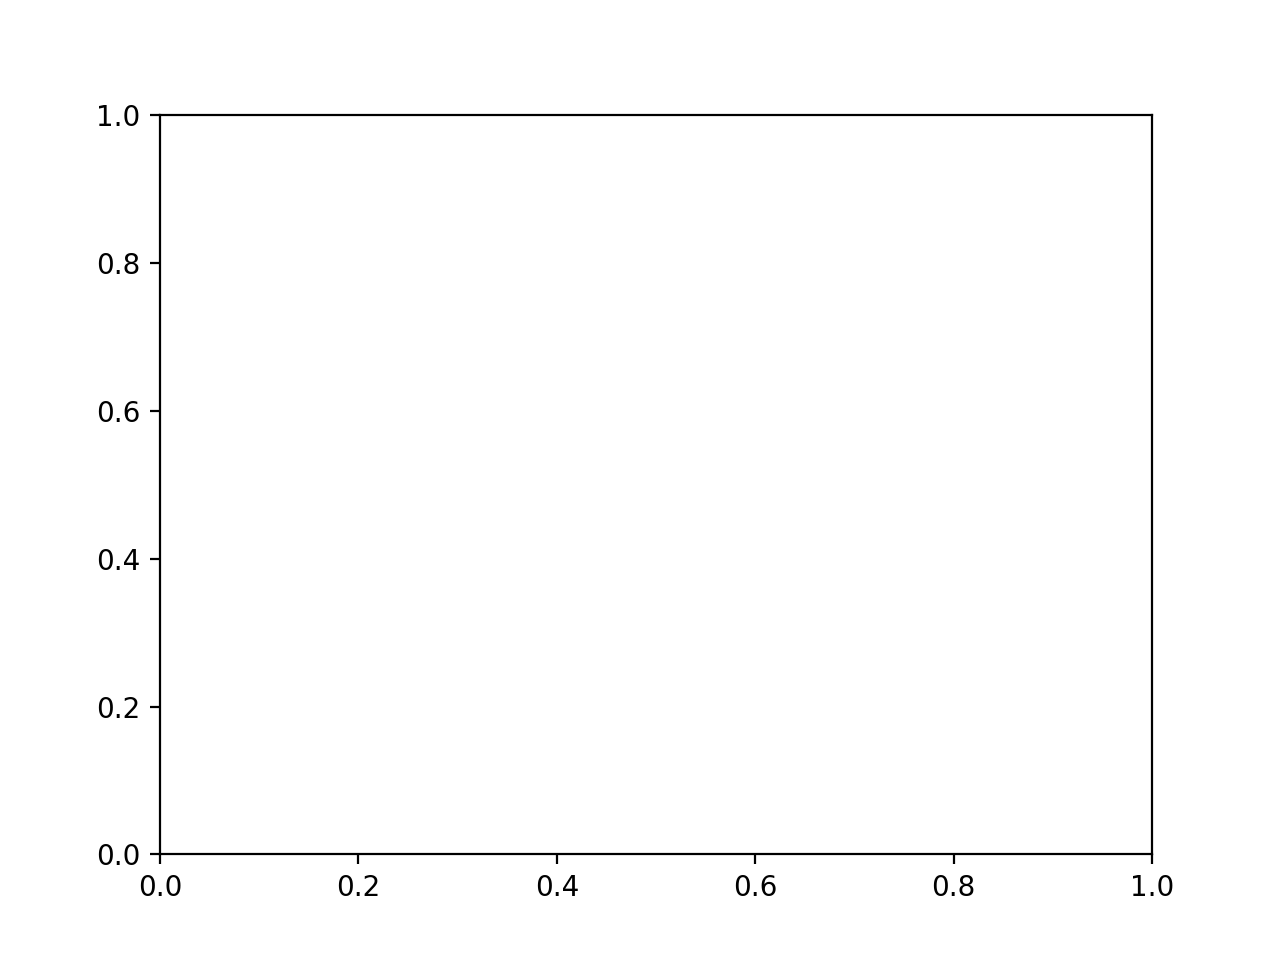

In [7]:
# take continuous data stream 
inputBufferSize = 10000 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#this is the problem line on the mac
# ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib notebook

total_time = 20.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()